In [11]:
%%writefile code_run.py
import h5py,os,tensorflow as tf
import pandas as pd,numpy as np
import seaborn as sn,pylab as pl
from tensorflow.keras.preprocessing \
import image as tkimg
from IPython.display import display,HTML

c1,f1,fs1='#FF355E','Smokum',25

def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

def del_png():
    png_list=[el for el in os.listdir('../content')
            if el[-4:]=='.png']
    for f in png_list: os.remove(f)

def randi(nmin,nmax): 
    return np.random.randint(nmin,nmax)

def randch(a): 
    return np.random.choice(a,1)[0]

def randcoef():
    a=(.5+.1**6*randi(1,999999))\
        *randch([-1,1])
    b=randi(3,12)
    c=.001*randi(1,99)*randch([-1,1])
    return a,b,c

def randcoord(a,b,c):
    t=np.arange(0,16*b*np.pi,1/(1440*b))
    fx=np.sin(t/6)+\
       a*np.sin(b*t)*np.cos(t)-\
       c*np.sin(16*b*t)
    fy=np.cos(t/6)+\
       a*np.sin(b*t)*np.sin(t)-\
       c*np.cos(16*b*t)
    return fx,fy

def randcol():
        return [np.random.random(3)]

def code_run(file_number):
    def img_size_display(fig_size):
        a,b,c=randcoef()
        dhtml('(a,b,c): %s'%str((a,b,c)))
        fx,fy=randcoord(a,b,c)
        pl.figure(figsize=(fig_size,fig_size))
        pl.scatter(fx,fy,s=.1**4,c=randcol())
        pl.axis('off')
        pl.tight_layout(pad=.05)
        fn='/content/example.png'
        pl.savefig(fn); pl.show();
 #   st="""<img id='01' src='example.png' alt='example' """+\
 #      """width='350' height='350'>"""
 #   display(HTML(st))
        img=tkimg.load_img(fn)
        img=tkimg.img_to_array(img)/255
        dhtml('image shape: %s'%str(img.shape))
        return img.shape[0]

    def randplot(idx,images,labels,targets,fig_size):
        a,b,c=randcoef()
        if (idx+1)%10==0:
            print('*',end='',flush=True)
        labels[idx]=b-3
        targets[idx]=[a,c]
        fx,fy=randcoord(a,b,c)
        pl.figure(figsize=(fig_size,fig_size))
        pl.scatter(fx,fy,s=.1**5,c=randcol())
        pl.axis('off')
        pl.tight_layout(pad=.05)
        fn='%03d'%idx+'.png'
        pl.savefig(fn); pl.close();
        img=tkimg.load_img(fn)
        img=tkimg.img_to_array(img)
        img=np.expand_dims(img,axis=0)/255
        images.append(img)
        os.remove(fn)

    def data_file(num_images,h5f,fig_size,img_size):
        images=[]
        labels=np.zeros((num_images,),dtype=np.int32)
        targets=np.zeros((num_images,2),dtype=np.float32)
        for idx in range(num_images):
            randplot(idx,images,labels,targets,fig_size)
        images=np.array(np.vstack(images),
                        dtype='float32')
        with h5py.File(h5f,'w') as f:
            f.create_dataset('images',data=images,
                             compression='gzip')
            f.create_dataset('labels',data=labels,
                             compression='gzip')
            f.create_dataset('targets',data=targets,
                             compression='gzip')
            f.close()
        print('\nfile size: %s'%list(os.stat(h5f))[6])
    fig_size1=3.12
    img_size1=img_size_display(fig_size1)
    h5f1='ArtificialImages'+str(img_size1)+'.h5'
    num_images1=100

    data_file(num_images1,file_number+h5f1,
              fig_size1,img_size1)   

Overwriting code_run.py


In [12]:
%run code_run.py
dhtml('Creating Labeled and Measured Synthetic Images')

<Figure size 432x288 with 0 Axes>

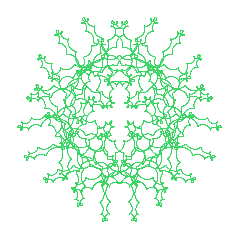

**********
file size: 4774779


In [13]:
code_run('01')

In [14]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf')

<Figure size 432x288 with 0 Axes>

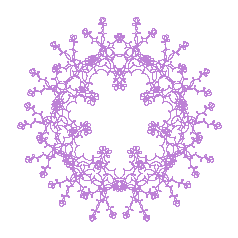

**********
file size: 4742152


In [15]:
%run code_run.py
code_run('02')

In [16]:
%run code_start.py
dhtml('Processing Synthetic Images')

<Figure size 432x288 with 0 Axes>

In [17]:
def h5file2data(h5list):
    images,labels,targets=[],[],[]
    for h5f in h5list:
        with h5py.File(h5f,'r') as f:
            keys=list(f.keys())
            images.append(list(f[keys[0]]))
            labels.append([list(f[keys[1]])])
            targets.append(list(f[keys[2]]))
            f.close()
    dhtml('file keys: '+', '.join(keys))
    images=np.vstack(images)
    labels=np.vstack(labels).reshape(-1)
    targets=np.vstack(targets)
    N=labels.shape[0]; n=int(.1*N)
    shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    images=images[shuffle_ids]
    labels=labels[shuffle_ids]
    targets=targets[shuffle_ids]
    x_test,x_valid,x_train=\
    images[:n],images[n:2*n],images[2*n:]
    ly_test,ly_valid,ly_train=\
    labels[:n],labels[n:2*n],labels[2*n:]
    ty_test,ty_valid,ty_train=\
    targets[:n],targets[n:2*n],targets[2*n:]
    dhtml('distribution of labels: ')
    df=pd.DataFrame(labels,columns=['label'])
    df['name']=['b=%d'%(l+3) for l in labels]
    pl.figure(figsize=(5,2.5))
    sn.countplot(y='name',data=df,
                 palette='autumn',alpha=.5)
    fn='countplot.png'
    pl.savefig(fn); pl.show();
#    st="""<img id='02' src='countplot.png' alt='countplot' """+\
#       """width='500' height='250'>"""
#    display(HTML(st))
    dhtml('function outputs: ')
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [ly_train.shape,ly_valid.shape,ly_test.shape],
                     [ly_train.dtype,ly_valid.dtype,ly_test.dtype],
                     [ty_train.shape,ty_valid.shape,ty_test.shape],
                     [ty_train.dtype,ty_valid.dtype,ty_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type',
                           'target shape','target type'])
    display(df)
    return x_train,x_valid,x_test,\
           ly_train,ly_valid,ly_test,\
           ty_train,ty_valid,ty_test

def checkplot(num,x,ly,ty):
    [a,c]=ty[num]; b=ly[num]+3
    dhtml('[num,(a,b,c)]: %s'%str([num,(a,b,c)]))
    fx,fy=randcoord(a,b,c)
    fig=pl.figure(figsize=(7,3.5))
    ax=fig.add_subplot(121)
    ax.scatter(fx,fy,s=.1**5,c=randcol())
    ax.set_axis_off()
    ax=fig.add_subplot(122)
    ax.imshow(x[num])
    ax.set_axis_off()
    pl.savefig('checkplot.png',bbox_inches='tight')
    pl.show();
#    st="""<img id='03' src='checkplot.png' alt='checkplot' """+\
#       """width='500' height='250'>"""
#    display(HTML(st))

In [18]:
%run code_run.py
h5list1=[el for el in os.listdir('../content')
           if el[-3:]=='.h5']
dhtml(', '.join(h5list1))

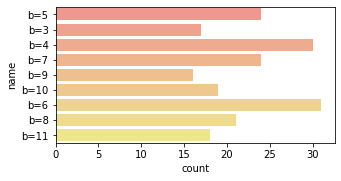

,train,valid,test
image shape,"(160, 224, 224, 3)","(20, 224, 224, 3)","(20, 224, 224, 3)"
image type,float32,float32,float32
label shape,"(160,)","(20,)","(20,)"
label type,int32,int32,int32
target shape,"(160, 2)","(20, 2)","(20, 2)"
target type,float32,float32,float32


In [19]:
x_train1,x_valid1,x_test1,\
ly_train1,ly_valid1,ly_test1,\
ty_train1,ty_valid1,ty_test1=\
h5file2data(h5list1)

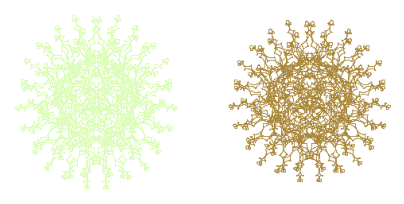

In [20]:
num1=np.random.randint(ly_train1.shape[0])
checkplot(num1,x_train1,ly_train1,ty_train1)